# Preparação inicial dos dados

In [1]:
import pandas as pd

In [2]:
# Dados de gelolocalização disponível no Kaggle
# https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_geolocation_dataset.csv
df = pd.read_csv('olist_geolocation_dataset.csv')

In [3]:
# Primeiras observações:
df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [4]:
# Tipos das variáveis:
df.dtypes

geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

In [5]:
# Dimensões do conjunto de dados:
df.shape

(1000163, 5)

In [6]:
# Distribuição dos registros por estado:
df.geolocation_state.value_counts()

SP    404268
MG    126336
RJ    121169
RS     61851
PR     57859
SC     38328
BA     36045
GO     20139
ES     16748
PE     16432
DF     12986
MT     12031
CE     11674
PA     10853
MS     10431
MA      7853
PB      5538
RN      5041
PI      4549
AL      4183
TO      3576
SE      3563
RO      3478
AM      2432
AC      1301
AP       853
RR       646
Name: geolocation_state, dtype: int64

In [7]:
# Arredondamento das coordenadas para 3 casas de precisão (erro aproximado de 100m)
# O objetivo aqui é somente reduzir a quantidade de pontos, após agregá-los
df['geolocation_lat'] = df['geolocation_lat'].round(3)
df['geolocation_lng'] = df['geolocation_lng'].round(3)
df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.546,-46.639,sao paulo,SP
1,1046,-23.546,-46.645,sao paulo,SP
2,1046,-23.546,-46.643,sao paulo,SP
3,1041,-23.544,-46.639,sao paulo,SP
4,1035,-23.542,-46.642,sao paulo,SP


In [8]:
# Agregando os pontos:
df_agg = df.groupby(['geolocation_lat', 'geolocation_lng']).agg(
    uf=('geolocation_state', 'min'),
    n_pontos=('geolocation_lat', 'count')
).reset_index()

In [9]:
df_agg.head()

,geolocation_lat,geolocation_lng,uf,n_pontos
0,-36.605,-64.284,RS,1
1,-36.604,-64.287,RS,2
2,-34.622,-58.902,BA,1
3,-34.586,-58.732,RJ,1
4,-33.693,-53.456,RS,1


In [10]:
df_agg.shape

(501771, 4)

In [11]:
# Distribuição dos registros aggregados por estado:
df_agg.uf.value_counts()

SP    173014
MG     70578
RJ     46626
RS     36784
PR     35804
SC     23784
BA     19527
GO     12506
PE     10088
ES      8465
CE      7998
MT      7617
MS      7327
PA      6539
DF      5980
MA      5125
PB      4011
RN      3427
PI      3090
AL      2658
TO      2599
RO      2224
SE      2157
AM      1770
AC       905
AP       637
RR       531
Name: uf, dtype: int64

# Garantindo somente dados de AL

In [12]:
import json
from shapely.geometry import Point, Polygon

In [13]:
# Como existe a possibilidade do campo UF possuir erros, o objetivo aqui é filtrar AL com base nas coordenadas

In [14]:
# Download das coordenadas do estado de MG disponível do GitHub:
# https://github.com/eduardo-veras/kml-brasil/tree/master/lib/2010/estados

In [15]:
with open('AL.json') as json_file:
    data_geo = json.load(json_file)
data_geo

{'state': {'code': 'AL', 'name': 'ALAGOAS', 'region': 'NORDESTE'},
 'borders': [[{'lat': -8.81743535016128, 'lng': -35.46752527047484},
   {'lat': -8.84200185260337, 'lng': -35.44948318400166},
   {'lat': -8.83623057028457, 'lng': -35.411225605976895},
   {'lat': -8.8498359656572, 'lng': -35.39457115813243},
   {'lat': -8.876555799410596, 'lng': -35.28765407227755},
   {'lat': -8.887233015691137, 'lng': -35.25278213328885},
   {'lat': -8.882722869764542, 'lng': -35.237837537672185},
   {'lat': -8.891763713824247, 'lng': -35.20909398290091},
   {'lat': -8.89056126269207, 'lng': -35.17123181699467},
   {'lat': -8.916386270110216, 'lng': -35.15195045125224},
   {'lat': -8.934752935399576, 'lng': -35.166986774120296},
   {'lat': -8.97744732953058, 'lng': -35.18124914223411},
   {'lat': -9.007142972270316, 'lng': -35.21581118743636},
   {'lat': -9.049027992747622, 'lng': -35.23881448559998},
   {'lat': -9.067336172426405, 'lng': -35.239090987559},
   {'lat': -9.087557566228671, 'lng': -35.2

In [16]:
# Converte as coordenadas em data frame:
df_borders = pd.DataFrame(data_geo['borders'][0])
df_borders.head()

,lat,lng
0,-8.817435,-35.467525
1,-8.842002,-35.449483
2,-8.836231,-35.411226
3,-8.849836,-35.394571
4,-8.876556,-35.287654


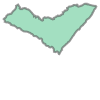

In [17]:
# Cria o polígono do estado de MG:
poligono = zip(list(df_borders.lng), list(df_borders.lat))
poligono = Polygon(poligono)
poligono

In [18]:
# Função para identificar se um ponto está dentro de um polígono
def within_polygon(lng, lat, polygon):
    point = Point(float(lng), float(lat))
    return point.within(polygon)

In [19]:
df_agg.head()

,geolocation_lat,geolocation_lng,uf,n_pontos
0,-36.605,-64.284,RS,1
1,-36.604,-64.287,RS,2
2,-34.622,-58.902,BA,1
3,-34.586,-58.732,RJ,1
4,-33.693,-53.456,RS,1


In [20]:
# Aplica a função para identificação dos pontos de AL:
df_agg['localizado_no_poligono'] = df_agg.apply(lambda x: within_polygon(
    x.geolocation_lng, x.geolocation_lat, poligono), axis=1)

In [21]:
df_agg.head()

,geolocation_lat,geolocation_lng,uf,n_pontos,localizado_no_poligono
0,-36.605,-64.284,RS,1,False
1,-36.604,-64.287,RS,2,False
2,-34.622,-58.902,BA,1,False
3,-34.586,-58.732,RJ,1,False
4,-33.693,-53.456,RS,1,False


In [22]:
# True = localizado no poligono:
df_agg.localizado_no_poligono.value_counts()

False    499186
True       2585
Name: localizado_no_poligono, dtype: int64

In [23]:
# Observa-se alguns erros no dataset ao cruzar os dados obtidos pela análise do polígono e a variável UF:
pd.crosstab(df_agg.uf, df_agg.localizado_no_poligono).reset_index()

localizado_no_poligono,uf,False,True
0,AC,905,0
1,AL,77,2581
2,AM,1770,0
3,AP,637,0
4,BA,19527,0
5,CE,7998,0
6,DF,5980,0
7,ES,8465,0
8,GO,12506,0
9,MA,5125,0


In [24]:
# Filtra somente os dados de AL (localizado_no_poligono = True)
df_al = df_agg[df_agg.localizado_no_poligono]
df_al.shape

(2585, 5)

# Plotando os pontos no mapa de Alagoas:

In [25]:
import geopandas as gpd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# Necessário fazer o download do shape file no site do IBGE
# https://www.ibge.gov.br/geociencias/organizacao-do-territorio/15774-malhas.html?=&t=downloads

In [27]:
# Carregando o shape file
shape_path = os.path.join('al_municipios', 'AL_Municipios_2019.shp')
shape_al = gpd.read_file(shape_path)

In [28]:
shape_al.head()

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry
0,2700102,Água Branca,AL,468.226,"POLYGON ((-37.96166 -9.25007, -37.96173 -9.250..."
1,2700201,Anadia,AL,186.134,"POLYGON ((-36.38463 -9.65499, -36.38484 -9.654..."
2,2700300,Arapiraca,AL,345.655,"POLYGON ((-36.73545 -9.73629, -36.75253 -9.710..."
3,2700409,Atalaia,AL,533.258,"POLYGON ((-36.15554 -9.47280, -36.15551 -9.472..."
4,2700508,Barra de Santo Antônio,AL,131.364,"POLYGON ((-35.53127 -9.43457, -35.53129 -9.434..."


In [29]:
df_al.head()

,geolocation_lat,geolocation_lng,uf,n_pontos,localizado_no_poligono
450272,-10.408,-36.435,AL,2,True
450276,-10.407,-36.434,AL,1,True
450277,-10.407,-36.432,AL,3,True
450278,-10.407,-36.431,AL,1,True
450279,-10.407,-36.430,AL,1,True


<AxesSubplot:>

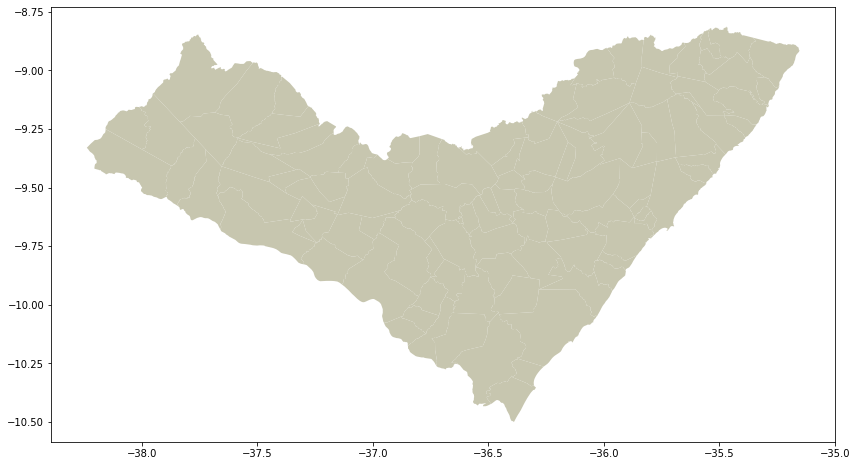

In [30]:
# Plotando os pontos:
# Não esquecer que x = longitude e y = latitude!!!

# Plotando apenas o mapa:
geometry = [Point(xy) for xy in zip(df_al['geolocation_lng'], df_al['geolocation_lat'])]
fig, ax = plt.subplots(figsize=(15,8))
shape_al.plot(ax=ax, color='#c7c6af')

<AxesSubplot:xlabel='geolocation_lng', ylabel='geolocation_lat'>

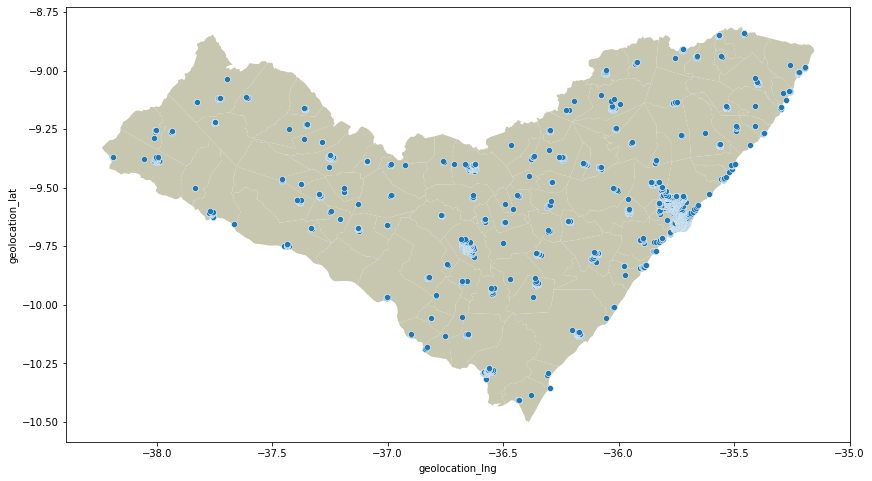

In [31]:
# Plotando os pontos sobre o mapa:
geometry = [Point(xy) for xy in zip(df_al['geolocation_lng'], df_al['geolocation_lat'])]
fig, ax = plt.subplots(figsize=(15,8))
shape_al.plot(ax=ax, color='#c7c6af')
sns.scatterplot(data=df_al, 
                x='geolocation_lng',
                y='geolocation_lat')

<AxesSubplot:xlabel='geolocation_lng', ylabel='geolocation_lat'>

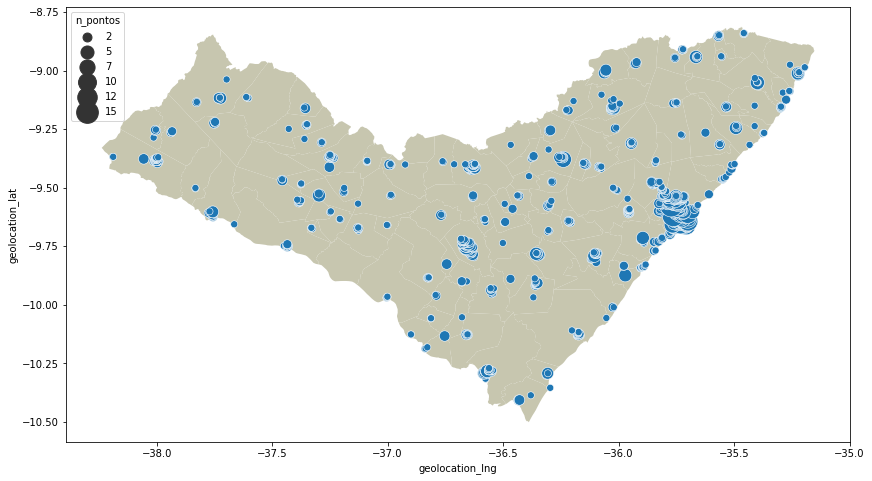

In [38]:
# Alterando o tamanho dos pontos em função da variável n_pontos:
geometry = [Point(xy) for xy in zip(df_al['geolocation_lng'], df_al['geolocation_lat'])]
fig, ax = plt.subplots(figsize=(15,8))
shape_al.plot(ax=ax, color='#c7c6af')
sns.scatterplot(data=df_al, 
                x='geolocation_lng',
                y='geolocation_lat',
                size='n_pontos',
                sizes=(50, 500))

<AxesSubplot:xlabel='geolocation_lng', ylabel='geolocation_lat'>

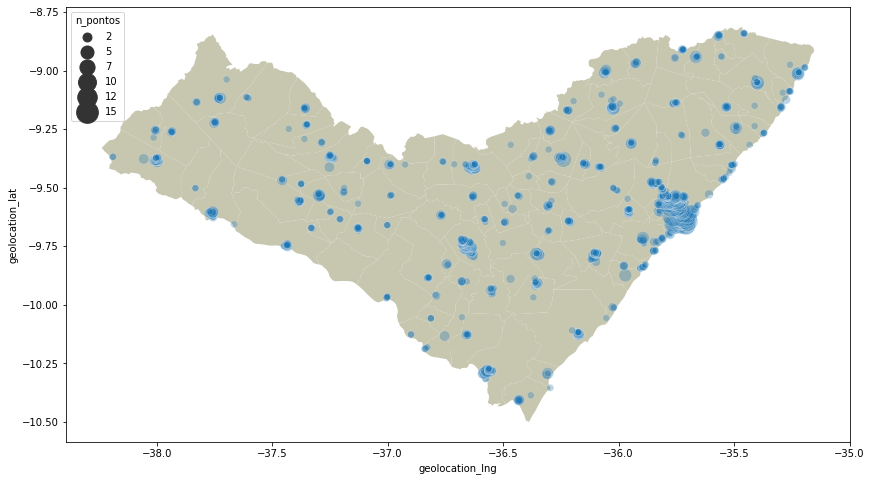

In [33]:
# Atribuindo transparência aos pontos para dar melhor noção de concentração:
geometry = [Point(xy) for xy in zip(df_al['geolocation_lng'], df_al['geolocation_lat'])]
fig, ax = plt.subplots(figsize=(15,8))
shape_al.plot(ax=ax, color='#c7c6af')
sns.scatterplot(data=df_al, 
                x='geolocation_lng',
                y='geolocation_lat',
                size='n_pontos',
                sizes=(50, 500), 
                alpha=0.3)

# Calculando a distância de Haversine:

In [34]:
from haversine import haversine, Unit, haversine_vector

In [35]:
# Matriz de distâncias (em km):
dij = df_al[['geolocation_lat', 'geolocation_lng']]
dij = [tuple(x) for x in dij.to_numpy()]
dij = haversine_vector(dij, dij, Unit.KILOMETERS, comb=True)

In [37]:
# Visualizando parte da matriz:
pd.DataFrame(dij).head(10)

,0,1,2,3,4,5,6,7,8,9,...,2575,2576,2577,2578,2579,2580,2581,2582,2583,2584
0,0.000000,0.155965,0.346428,0.451373,0.558019,0.665549,0.247827,0.692856,6.493717,16.345924,...,197.556510,197.609334,197.601278,197.804337,197.857157,204.129377,204.301774,204.663897,204.586051,204.623440
1,0.155965,0.000000,0.218732,0.328098,0.437463,0.546829,0.111195,0.558021,6.350825,16.203496,...,197.406336,197.459140,197.451136,197.654165,197.706965,203.977330,204.149679,204.511775,204.433986,204.471401
2,0.346428,0.218732,0.000000,0.109366,0.218732,0.328098,0.245373,0.346428,6.147935,15.999925,...,197.300868,197.353578,197.345813,197.548708,197.601413,203.862644,204.034737,204.396683,204.319203,204.356756
3,0.451373,0.328098,0.109366,0.000000,0.109366,0.218732,0.346428,0.245373,6.046904,15.898291,...,197.248204,197.300868,197.293222,197.496049,197.548708,203.805366,203.977330,204.339200,204.261875,204.299498
4,0.558019,0.437463,0.218732,0.109366,0.000000,0.109366,0.451375,0.155966,5.946168,15.796760,...,197.195587,197.248204,197.240678,197.443437,197.496049,203.748130,203.919966,204.281761,204.204590,204.242282
5,0.665549,0.546829,0.328098,0.218732,0.109366,0.000000,0.558021,0.111195,5.845743,15.695334,...,197.143017,197.195587,197.188181,197.390872,197.443437,203.690937,203.862644,204.224364,204.147348,204.185110
6,0.247827,0.111195,0.245373,0.346428,0.451375,0.558021,0.000000,0.546831,6.310796,16.163408,...,197.308954,197.361785,197.353714,197.556781,197.609606,203.882680,204.055110,204.417252,204.339367,204.376739
7,0.692856,0.558021,0.346428,0.245373,0.155966,0.111195,0.546831,0.000000,5.802229,15.653943,...,197.045505,197.098101,197.090628,197.293357,197.345948,203.596154,203.767941,204.129708,204.052595,204.090313
8,6.493717,6.350825,6.147935,6.046904,5.946168,5.845743,6.310796,5.802229,0.000000,9.852772,...,192.553762,192.604530,192.601700,192.801756,192.852522,198.927244,199.094197,199.453098,199.381779,199.422082
9,16.345924,16.203496,15.999925,15.898291,15.796760,15.695334,16.163408,15.653943,9.852772,0.000000,...,185.253462,185.300787,185.306586,185.501489,185.548816,191.291718,191.449526,191.802804,191.742343,191.787434


In [42]:
# Para calcular a distância entre dois particulares pontos:
# https://pypi.org/project/haversine/

# formato (lat, lon)
estadio_morumbi = (-23.599882, -46.720047)
estadio_couto_pereira = (-25.420721, -49.259491)

haversine(estadio_morumbi, estadio_couto_pereira) # Em quilômetros

327.10024736120977

In [44]:
haversine(estadio_morumbi, estadio_couto_pereira, unit=Unit.METERS) # Em metros

327100.24736120977

In [45]:
haversine(estadio_morumbi, estadio_couto_pereira, unit=Unit.MILES) # Em milhas

203.25067060632978